In [31]:
import os
os.environ['PROJ_LIB'] = r'C:\Users\regin\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'
#os.environ['PROJ_LIB'] = r'C:\Users\Work\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches           #for land-sea mask
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

In [32]:
#dir = '/Users/Work/Desktop/Regine_project/data/' #change dir
dir1 = '/Users/regin/Desktop/R/S2Scalibrationextremeheat/VerificationinR/RAWHINDCASTvsOBS(MARCH)/'
dir2 = '/Users/regin/Desktop/R/S2Scalibrationextremeheat/VerificationinR/CALIBRATEDHINDCASTvsOBS(MARCH)/'
method = 'MVA' #change method accordingly: MVA, CCR, LR

raw_file = dir1 + 'crps_fcst_raw_new.nc'
raw_data = Dataset(raw_file, mode='r')
cal_file = dir2 + 'crps_fcst_cal_' + method + '_new.nc'
cal_data = Dataset(cal_file, mode='r')

In [33]:
# Land-sea mask
dir3 = '/Users/regin/Desktop/R/S2Scalibrationextremeheat/notebooks/'
mask_file = dir3 + 'era5_lsm.nc'
mask_data = Dataset(mask_file, mode='r')
mask_lsm = mask_data.variables['lsm'][:]
mask_lsm = mask_lsm[:,::-1,:] #have to reverse lat into asc.
print(mask_lsm.shape)
mask_lsm = np.ma.masked_less_equal(mask_lsm,0.3) # decide the cut-off fraction is 0.3, for full-ocean 0, for full-land 1
mask_lsm[mask_lsm >=0.3] = 1 # change all valid entries to 1
print(mask_lsm)
print("total count: " + str(np.sum(~np.isnan(mask_lsm))))

(1, 31, 51)
[[[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... 1.0 1.0 1.0]
  ...
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]]
total count: 355


In [34]:
lons = raw_data.variables['lon'][:]
lats = raw_data.variables['lat'][:]
raw_tass = raw_data.variables['calculate_crps_fcst_raw_new'][:]
cal_tass = cal_data.variables['calculate_crps_fcst_cal_'+method][:]
raw_data.close()
cal_data.close()
print(raw_tass.shape)
print(cal_tass.shape)
#Compute skill score
skill_score = np.empty([24, len(lats),len(lons)]) # 1993 to 2016: 24 years
print(skill_score.shape)
skill_score = np.mean(1-(cal_tass/raw_tass), axis=0) #average year-axis
print(skill_score.shape)
skill_score = skill_score * mask_lsm #apply lsm
max = np.max(skill_score)
min = np.min(skill_score)
ave = np.mean(skill_score)
print("Skill score greater than zero for land areas Total counts " + str(np.sum(skill_score>0)))
print(skill_score)

(24, 31, 51)
(24, 31, 51)
(24, 31, 51)
(31, 51)
Skill score greater than zero for land areas Total counts 228
[[[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -0.0018489807844161987 -0.16743570566177368
   -0.16650396585464478]
  ...
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]]


C:\Users\regin\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
C:\Users\regin\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\regin\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\regin\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\regin\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: MatplotlibDeprecationWarning: 
The dedent function was deprecated in 

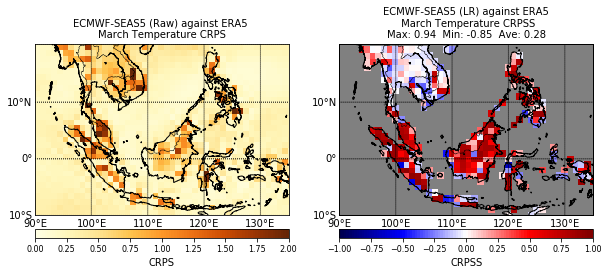

In [35]:
# Get some parameters for the Mercator Projection
lon_0 = lons.mean()
lat_0 = lats.mean()

fig = plt.figure(figsize=(10,10))

#first plot
ax = fig.add_subplot(1,2,1)

m = Basemap(llcrnrlon=90, llcrnrlat=-10, 
            urcrnrlon=135,urcrnrlat=20,
            projection='merc', resolution = 'i',
            lon_0=lon_0, lat_0=lat_0)

# Because our lon and lat variables are 1D, use meshgrid to create 2D arrays
lon, lat = np.meshgrid(lons, lats)
xi, yi = m(lon, lat)

# Set the color scale
label = "CRPS"

# Plot Data
cs = m.pcolormesh(xi,yi,np.squeeze(np.mean(raw_tass,axis=0)),cmap=plt.cm.get_cmap('YlOrBr',100))

# Add Grid Lines
m.drawparallels(np.arange(-10., 30., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(90., 150., 10.), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()

# Add Colorbar
cbar = m.colorbar(cs, location='bottom', pad="8%")
plt.clim(0,2)
cbar.set_label(label,fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Add Suptitle and Title
plt.title('ECMWF-SEAS5 (Raw) against ERA5 \nMarch Temperature CRPS',fontsize=10)

# Second plot
ax = fig.add_subplot(1,2,2)

m = Basemap(llcrnrlon=90, llcrnrlat=-10, 
            urcrnrlon=135,urcrnrlat=20,
            projection='merc', resolution = 'i',
            lon_0=lon_0, lat_0=lat_0)

# Because our lon and lat variables are 1D, use meshgrid to create 2D arrays
lon, lat = np.meshgrid(lons-0.5, lats-0.5) #slight alightment 1.0deg/2=0.5deg
xi, yi = m(lon, lat)

# Set the label
label = "CRPSS"

# Plot Data
#cs = m.pcolormesh(xi,yi,np.squeeze(skill_score),cmap=plt.cm.get_cmap('seismic_r',100))
cs = m.pcolormesh(xi,yi,np.squeeze(skill_score),cmap=plt.cm.get_cmap('seismic',100))

# Add Grid Lines
m.drawparallels(np.arange(-10., 30., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(90., 150., 10.), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawmapboundary(fill_color='grey')
m.drawcoastlines()
m.drawstates()
m.drawcountries()

# Add Colorbar
cbar = m.colorbar(cs, location='bottom', pad="8%")
plt.clim(-1,1)
cbar.set_label(label,fontsize=10)
cbar.ax.tick_params(labelsize=8)
#ax.patch.set(hatch="x")

# Add Suptitle and Title
plt.title('ECMWF-SEAS5 (' + method + ') against ERA5\n March Temperature CRPSS\n' + 'Max: ' + str("%.2f" % max) + '  Min: ' + str("%.2f" % min) + '  Ave: ' + str("%.2f" % ave),fontsize=10)

#plt.tight_layout()
plt.show()